In [253]:
from qiskit import Aer, QuantumCircuit, transpile, execute
from qiskit.circuit import Parameter
import numpy as np
from scipy.optimize import minimize
from qiskit.visualization import plot_histogram

In [254]:
from qiskit import Aer, QuantumCircuit, transpile, execute
import numpy as np

# Step 1: Define the QCBM Circuit
def qcbm_circuit(params, num_qubits, num_layers=2):
    """
    Construct a QCBM circuit with the specified number of layers (d).
    
    Args:
        params (np.ndarray): Array of parameters (size: num_qubits * 3 * num_layers).
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        
    Returns:
        QuantumCircuit: The parameterized QCBM circuit.
    """
    qc = QuantumCircuit(num_qubits)
    idx = 0

    for layer in range(num_layers):
        # Single-qubit rotations for each qubit in the layer
        for q in range(num_qubits):
            qc.rz(params[idx], q)
            qc.rx(params[idx + 1], q)
            qc.rz(params[idx + 2], q)
            idx += 3
        # Add entangling gates
        for q in range(num_qubits - 1):
            qc.cx(q, q + 1)
    return qc


In [255]:
# Step 2: Define the Loss Function
def loss_function(params, num_qubits, num_layers, target_distribution):
    """
    Calculate the KL divergence between target and generated distributions.
    
    Args:
        params (np.ndarray): Current parameters of the QCBM circuit.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        
    Returns:
        float: KL divergence.
    """
    qc = qcbm_circuit(params, num_qubits, num_layers)
    qc.measure_all()

    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    qc = transpile(qc, simulator)
    result = execute(qc, backend=simulator, shots=8000).result()
    counts = result.get_counts()
    
    # Convert counts to probabilities
    generated_distribution = {k: v / 8000 for k, v in counts.items()}
    
    # Calculate KL divergence
    kl_divergence = 0
    for bitstring, target_prob in target_distribution.items():
        generated_prob = generated_distribution.get(bitstring, 1e-10)
        kl_divergence += target_prob * np.log(target_prob / generated_prob)
    
    return kl_divergence


In [256]:
def gradient_computer(params,params_shift,num_qubits,  num_layers, target_distribution):
    qc_a = qcbm_circuit(params, num_qubits, num_layers)
    qc_a.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_a = transpile(qc_a, simulator)
    result_a = execute(qc_a, backend=simulator, shots=8000).result()
    counts_a = result_a.get_counts()
    
    # Normalize counts to probabilities
    generated_distribution_a = {k: v / 8000 for k, v in counts_a.items()}
    
    qc_b = qcbm_circuit(params_shift, num_qubits, num_layers)
    qc_b.measure_all()

    simulator = Aer.get_backend('qasm_simulator')
    qc_b = transpile(qc_b, simulator)
    result_b = execute(qc_b, backend=simulator, shots=8000).result()
    counts_b = result_b.get_counts()

    # Normalize counts to probabilities
    generated_distribution_b = {k: v / 8000 for k, v in counts_b.items()}
    
    gradient_component=0
    for bitstring, target_prob in target_distribution.items():
        generated_prob_a = generated_distribution_a.get(bitstring, 1e-10)
        generated_prob_b = generated_distribution_b.get(bitstring, 1e-10)
        gradient_component -=  target_prob /generated_prob_a*generated_prob_b
        
    return gradient_component

In [257]:

# Step 3: Define the Gradient Computation
def compute_gradients(params, num_qubits, num_layers, target_distribution):
    """
    Compute gradients of the loss function using the parameter-shift rule.
    
    Args:
        params (np.ndarray): Current parameters of the QCBM circuit.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        
    Returns:
        np.ndarray: Gradients of the loss function w.r.t. parameters.
    """
    gradients = np.zeros_like(params)
    shift = np.pi / 2  # Parameter shift value

    for i in range(len(params)):
        # Shift parameter up
        params_shifted_up = np.copy(params)
        params_shifted_up[i] += shift
        loss_up = gradient_computer(params, params_shifted_up, num_qubits, num_layers, target_distribution)

        # Shift parameter down
        params_shifted_down = np.copy(params)
        params_shifted_down[i] -= shift
        loss_down = gradient_computer(params, params_shifted_down, num_qubits, num_layers, target_distribution)

        # Compute gradient
        gradients[i] =loss_up - loss_down

    return gradients

In [258]:
# Step 4: Gradient Descent Training
def gradient_descent(initial_params, num_qubits, num_layers, target_distribution, learning_rate=0.1, max_iters=100):
    """
    Perform gradient descent to optimize QCBM parameters.
    
    Args:
        initial_params (np.ndarray): Initial QCBM parameters.
        num_qubits (int): Number of qubits.
        num_layers (int): Number of layers (d).
        target_distribution (dict): Target probability distribution.
        learning_rate (float): Learning rate for parameter updates.
        max_iters (int): Maximum number of iterations.
        
    Returns:
        np.ndarray: Optimized parameters.
    """
    params = np.copy(initial_params)
    for iteration in range(max_iters):
        # Compute gradients
        gradients = compute_gradients(params, num_qubits, num_layers, target_distribution)
        
        # Update parameters
        params -= learning_rate * gradients
        
        # Compute loss for monitoring
        loss = loss_function(params, num_qubits, num_layers, target_distribution)
        print(f"Iteration {iteration + 1}, Loss: {loss}")
        if loss<0.1:
            break
    
    return params


In [259]:
def gaussian_target_distribution(num_qubits):
    num_states = 2**num_qubits  # Total basis states
    mid_point = (num_states - 1) / 2  # Center the distribution
    
    # Map basis states to integers and calculate probabilities
    probabilities = []
    for i in range(num_states):
        x = i - mid_point  # Centered integer value
        prob = np.exp(-(x/4)**2 / 2)  # Gaussian probability
        probabilities.append(prob)
    
    # Normalize probabilities
    probabilities = np.array(probabilities)
    probabilities /= np.sum(probabilities)
    
    # Create target distribution as a dictionary
    target_distribution = {format(i, f'0{num_qubits}b'): prob for i, prob in enumerate(probabilities)}
    return target_distribution

In [260]:
# Step 5: Train the QCBM
num_qubits = 6
num_layers = 2
num_params = num_qubits * 3 * num_layers
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., |110⟩ with 0.8 probability, |001⟩ with 0.2 probability)
target_distribution = gaussian_target_distribution(num_qubits)

# Train using gradient descent
optimized_params = gradient_descent(
    initial_params, 
    num_qubits, 
    num_layers, 
    target_distribution, 
    learning_rate=0.1, 
    max_iters=100
)


Iteration 1, Loss: 3.4071994068051064
Iteration 2, Loss: 5.574586114465163
Iteration 3, Loss: 1.821871749056599
Iteration 4, Loss: 11.96004814370931
Iteration 5, Loss: 2.218834585161748
Iteration 6, Loss: 1.5398791486209105
Iteration 7, Loss: 2.441200139205226
Iteration 8, Loss: 2.2063007829216117
Iteration 9, Loss: 1.8062698224539802
Iteration 10, Loss: 2.159024548185748
Iteration 11, Loss: 1.5780635267500804
Iteration 12, Loss: 2.0869661705034757
Iteration 13, Loss: 2.148996630175172
Iteration 14, Loss: 5.126272922711442
Iteration 15, Loss: 2.8738294205385535
Iteration 16, Loss: 4.775184012734343
Iteration 17, Loss: 3.0139512620306483
Iteration 18, Loss: 3.7294824334423566
Iteration 19, Loss: 3.1467178845792603
Iteration 20, Loss: 1.3052831388511048
Iteration 21, Loss: 1.7940028036795397
Iteration 22, Loss: 4.031312211435924
Iteration 23, Loss: 2.6316732839232087
Iteration 24, Loss: 2.659173174766128
Iteration 25, Loss: 1.5720127751761572
Iteration 26, Loss: 1.2033892540605362
Iterat

In [261]:
# Step 6: Generate Samples Using Trained QCBM
trained_qcbm = qcbm_circuit(optimized_params, num_qubits, num_layers)
trained_qcbm.measure_all()

simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm, simulator)
result = execute(trained_qcbm, backend=simulator, shots=8000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)


Generated Distribution: {'111011': 1, '000110': 2, '111111': 4, '000010': 4, '000011': 3, '111000': 6, '110110': 22, '001110': 48, '111101': 10, '001111': 65, '110101': 27, '110000': 57, '001011': 49, '011011': 159, '001001': 27, '000100': 3, '000001': 6, '100101': 58, '011010': 88, '101011': 246, '110010': 66, '110100': 66, '101110': 93, '011000': 109, '101000': 197, '001100': 37, '011001': 107, '110111': 30, '010011': 52, '001010': 41, '111010': 4, '111100': 9, '001000': 35, '010101': 114, '101100': 71, '100111': 61, '010000': 151, '100110': 76, '000111': 1, '010100': 245, '000000': 9, '000101': 2, '011101': 507, '110001': 69, '111001': 3, '100001': 563, '101010': 177, '011110': 547, '111110': 8, '100000': 628, '100100': 158, '010010': 103, '110011': 39, '101101': 96, '010111': 127, '010110': 118, '010001': 101, '011100': 440, '101111': 145, '101001': 129, '100010': 490, '100011': 380, '011111': 641, '001101': 70}


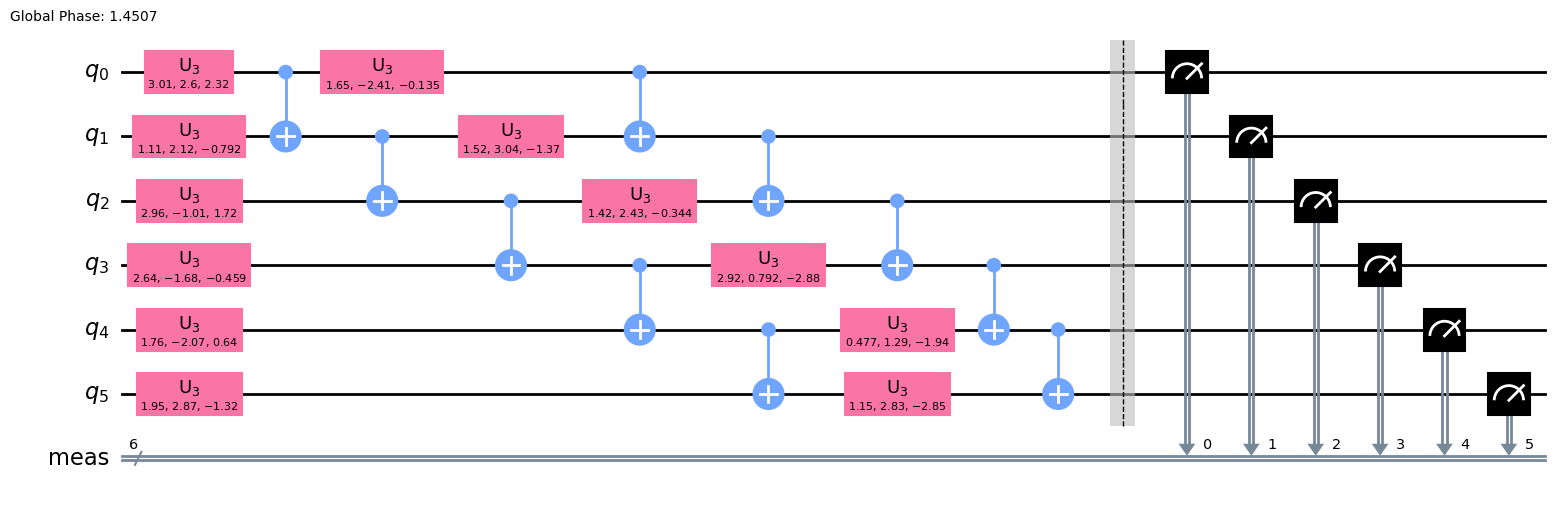

In [262]:
trained_qcbm.draw(output="mpl")

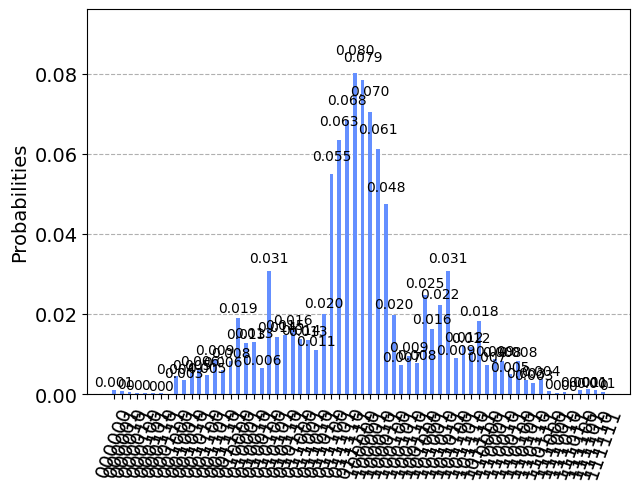

In [263]:
plot_histogram(counts)

In [278]:
num_qubits = 6
num_layers = 2
num_params = num_qubits * 3 * num_layers
initial_params = np.random.uniform(0, 2 * np.pi, num_params)

# Define target distribution (e.g., |110⟩ with 0.8 probability, |001⟩ with 0.2 probability)
target_distribution = gaussian_target_distribution(num_qubits)

result_cob = minimize(loss_function, initial_params, args=(num_qubits,num_layers, target_distribution), method='COBYLA')

# Optimized parameters
optimized_params_cob = result_cob.x
final_result=result_cob.fun
print(final_result)

0.12231552417170347


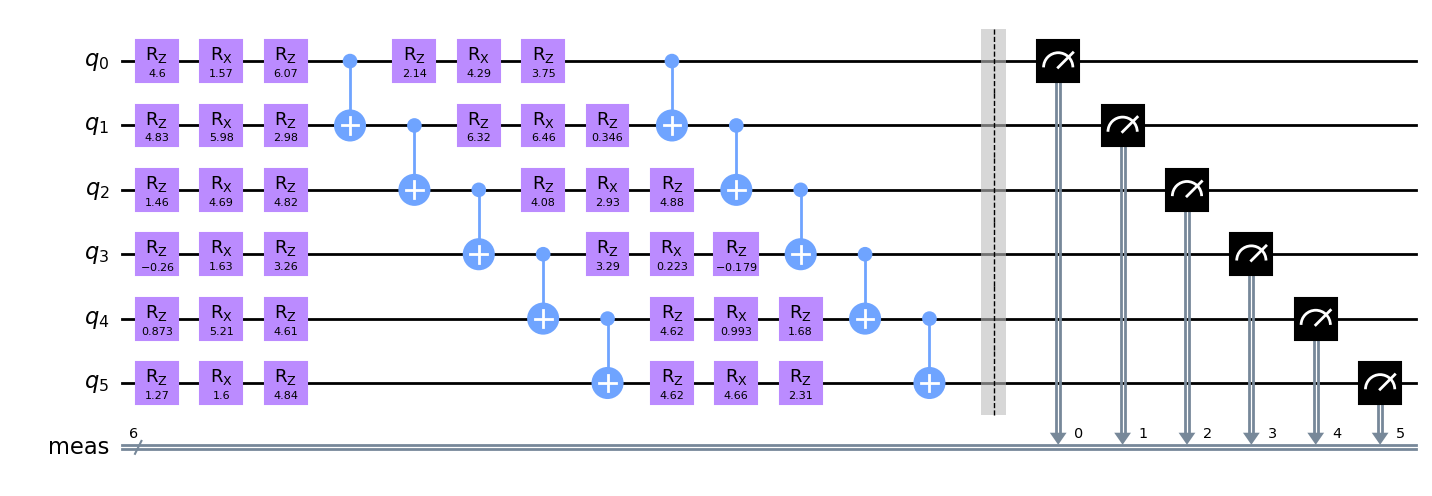

In [279]:
trained_qcbm_cob = qcbm_circuit(optimized_params_cob, num_qubits, num_layers)
trained_qcbm_cob.measure_all()
trained_qcbm_cob.draw(output="mpl")

In [280]:
simulator = Aer.get_backend('qasm_simulator')
trained_qcbm = transpile(trained_qcbm_cob, simulator)
result = execute(trained_qcbm_cob, backend=simulator, shots=8000).result()
counts = result.get_counts()

print("Generated Distribution:", counts)

Generated Distribution: {'111011': 1, '000111': 1, '110110': 3, '111010': 1, '111100': 2, '001000': 4, '110001': 1, '000101': 2, '011101': 434, '000000': 1, '011011': 428, '001001': 8, '001011': 7, '111000': 2, '001110': 2, '011001': 309, '110111': 4, '010011': 5, '011100': 450, '101111': 5, '110101': 3, '001111': 3, '101101': 7, '110011': 2, '010010': 7, '000011': 1, '101001': 133, '011010': 423, '110000': 3, '110100': 5, '101110': 10, '100100': 460, '011000': 314, '101100': 2, '100111': 305, '001010': 9, '001100': 2, '101000': 130, '100110': 268, '010000': 13, '100001': 547, '011110': 509, '111110': 2, '100000': 613, '010100': 118, '101010': 129, '010101': 123, '100011': 405, '010111': 117, '010001': 8, '010110': 148, '011111': 552, '110010': 1, '101011': 117, '100010': 415, '100101': 424, '001101': 2}


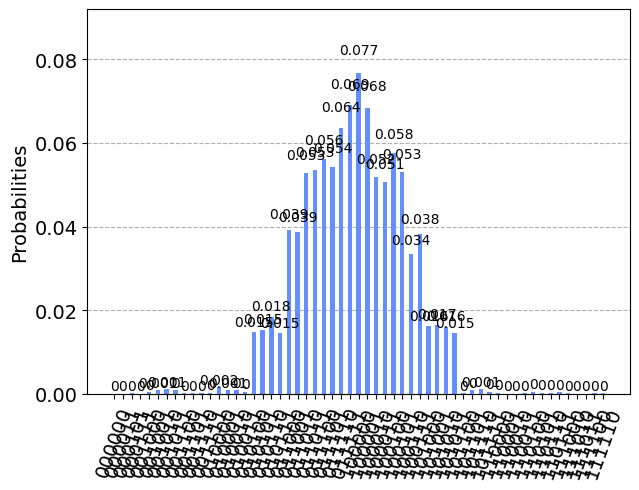

In [281]:
plot_histogram(counts)

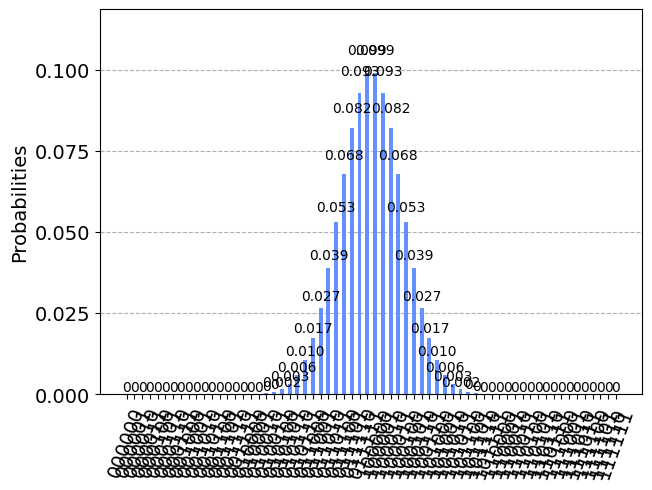

In [282]:
plot_histogram(target_distribution)